In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib as mpl

### Colors and groups

In [9]:
mrv_topic_colors = {
    'Quantification': '#7da7b8',   # darker bluish-grey
    'Monitoring': '#8dc39f',        # stronger soft green
    'Quality': '#c76a85',           # berry red
    'Governance': '#b39bc8',        # stronger lavender
    'Reporting': '#e1a6b8',         # stronger soft pink
    'Verification': '#a8a8a8',      # medium grey
    'External impacts': '#d0c97b',   # stronger soft yellow
    'General MRV': '#e5b138',      # muted yellow
    
}

cdr_method_colors = {
    
    'SCS': '#a47551', 
    
    'A/R': '#238b45', 
    'General forestry': '#66c2a4', 
    'Agroforestry': '#b2e2e2', 
    'Forest management': '#edf8fb',

    'Biochar': '#ce1256',
    'Restoration of landscapes and peats': '#df65b0',
    'EW': '#d7b5d8', 
  
    'OAE': '#016c59', 
    'OIF/AU': '#1c9099', 
    'DOC': '#67a9cf',
    'Algae ': '#bdc9e1', 
    'Blue carbon': '#f6eff7',
       
    'CCS': '#e31a1c',
    'BECCS': '#fd8d3c', 
    'DACCS': '#fecc5c',
    'CCUS': '#ffffb2', 
    
    'General CDR': '#525252', 
    'Other': '#969696',    
}

### Data & cleaning

In [10]:
df = pd.read_excel("MRVdata_2210.xlsx") # older version: MRVdata_0810 ?
df_filtered = df[df['Year'] != 2024]
df_included = df_filtered[df_filtered['Inclusion/exclusion'] == 'Inclusion'].copy()

### additonal data

def extract_CDR_method_focus(row):
    CDR_method = []
    CDR_focus = []
    
    for column in cdr_method_colors.keys():  # previously defined list with columns that contain CDR methods
        if row[column] > 0:
            CDR_method.append(column)
            CDR_focus.append(row[column])
    
    return [CDR_method, CDR_focus]
# add new columns to the data frame
df_included['CDR_focus'] = df_included.apply(lambda row: extract_CDR_method_focus(row), axis=1)
df_included['CDR_method'] = df_included.CDR_focus.str[0]
df_included['CDR_focus'] = df_included.CDR_focus.str[1]


#add new column for MRV topic and study focus to the dataset
def extract_MRV_topic_focus(row):
    MRV_topic = []
    MRV_focus = []
    
    for column in mrv_topic_colors.keys():  # previously defined list with columns that contain MRV topics
        if row[column] > 0:
            MRV_topic.append(column)
            MRV_focus.append(row[column])
    
    return [MRV_topic, MRV_focus]
# add new columns to the data frame
df_included['MRV_focus'] = df_included.apply(lambda row: extract_MRV_topic_focus(row), axis=1)
df_included['MRV_topic'] = df_included.MRV_focus.str[0]
df_included['MRV_focus'] = df_included.MRV_focus.str[1]


### explode
# explode CDR method and focus
df_CDRexplode = df_included.explode(['CDR_method', 'CDR_focus'])

# explode MRV topic and focus
df_MRVexplode = df_included.explode(['MRV_topic', 'MRV_focus'])

### Publication per years

In [20]:
paper_per_year = df_included.groupby("Year", as_index=False).size()

Text(0, 0.5, 'Number of \nPublications')

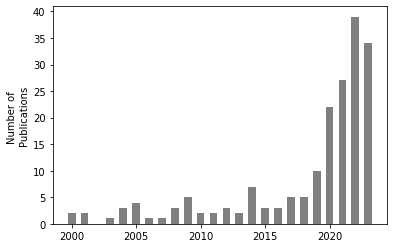

In [22]:
fig, ax = plt.subplots()
width=0.6

ax.bar(paper_per_year["Year"], paper_per_year["size"], width, color="grey")
ax.set_ylabel('Number of \nPublications')

### Focus plots

In [33]:
col_focus = {
    1:'#87CEEB', 
    2:'#6CA6CD', 
    3:'#4A708B'
}

In [46]:
cdr_meth = df_CDRexplode.groupby(['CDR_method'],as_index=False).size().rename(columns={"size":"total_size"}) 
cdr_meth_focus = df_CDRexplode.groupby(['CDR_method', 'CDR_focus'],as_index=False).size() 
for m in cdr_meth["CDR_method"]:
    for f in [1,2,3]:
        if cdr_meth_focus.loc[(cdr_meth_focus.CDR_method==m)&(cdr_meth_focus["CDR_focus"]==f)].shape[0]==0:
                one_row = pd.DataFrame({'CDR_method': [m], 'CDR_focus': [f], 'size': [0]})
                cdr_meth_focus = pd.concat([cdr_meth_focus, one_row])
cdr_meth_focus = cdr_meth_focus.merge(cdr_meth, on="CDR_method")
cdr_meth_focus["rel"] = cdr_meth_focus["size"]/cdr_meth_focus["total_size"]

cdr_meth_focus["col"] = cdr_meth_focus.CDR_focus.replace(col_focus)

# sorting
cdr_meth_focus.CDR_method = cdr_meth_focus.CDR_method.astype("category")
cdr_meth_focus.CDR_method = cdr_meth_focus.CDR_method.cat.set_categories(cdr_method_colors.keys())
cdr_meth_focus = cdr_meth_focus.sort_values("CDR_method")

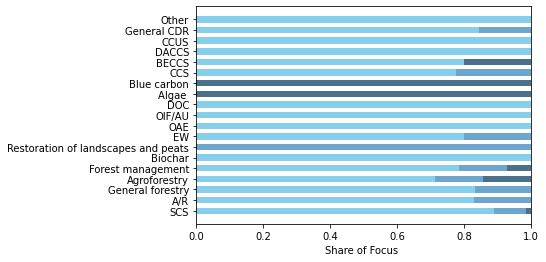

In [68]:
fig, ax = plt.subplots()
focus = [1,2,3]

prev_values = np.zeros(len(cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==focus[0]]))
for i, f in enumerate(focus):
    #print(topic)
    ax.barh([i for i in range(len(cdr_method_colors.keys()))], cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==f,"rel"], 
              width, left=prev_values, 
              label=f,
              color=cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==f,"col"])
    prev_values += np.array(cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==f,"rel"])
    
ax.set_xlabel('Share of Focus ')
_=ax.set_yticks([i for i in range(len(cdr_method_colors.keys()))],[i for i in cdr_method_colors.keys()])

In [56]:
cdr_mrv = df_MRVexplode.groupby(['MRV_topic'],as_index=False).size().rename(columns={"size":"total_size"}) 
cdr_mrv_focus = df_MRVexplode.groupby(['MRV_topic', 'MRV_focus'],as_index=False).size() 
for m in cdr_mrv["MRV_topic"]:
    for f in [1,2,3]:
        if cdr_mrv_focus.loc[(cdr_mrv_focus.MRV_topic==m)&(cdr_mrv_focus["MRV_focus"]==f)].shape[0]==0:
                one_row = pd.DataFrame({'MRV_topic': [m], 'MRV_focus': [f], 'size': [0]})
                cdr_mrv_focus = pd.concat([cdr_mrv_focus, one_row])
cdr_mrv_focus = cdr_mrv_focus.merge(cdr_mrv, on="MRV_topic")
cdr_mrv_focus["rel"] = cdr_mrv_focus["size"]/cdr_mrv_focus["total_size"]

cdr_mrv_focus["col"] = cdr_mrv_focus.MRV_focus.replace(col_focus)

# sorting
cdr_mrv_focus.MRV_topic = cdr_mrv_focus.MRV_topic.astype("category")
cdr_mrv_focus.MRV_topic = cdr_mrv_focus.MRV_topic.cat.set_categories(mrv_topic_colors.keys())
cdr_mrv_focus = cdr_mrv_focus.sort_values("MRV_topic")

In [63]:
cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"rel"]

15    0.896341
9     0.500000
12    0.481481
6     0.400000
18    0.500000
21    0.428571
0     0.571429
3     0.888889
Name: rel, dtype: float64

In [77]:
 len(cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"rel"].values)

8

In [79]:
np.zeros(len(cdr_mrv_focus.loc[cdr_mrv_focus["MRV_topic"]==focus[0]]))

array([], dtype=float64)

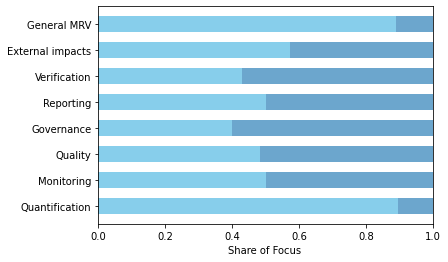

In [80]:
fig, ax = plt.subplots()
focus = [1,2,3]

prev_values = np.zeros(len(cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==focus[0]]))
for i, f in enumerate(focus):
    ax.barh([i for i in range(len(mrv_topic_colors.keys()))], cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"rel"], 
              width, left=prev_values, 
              label=f,
              color=cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"col"])
    prev_values += np.array(cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"rel"])
    
ax.set_xlabel('Share of Focus ')
_=ax.set_yticks([i for i in range(len(mrv_topic_colors.keys()))],[i for i in mrv_topic_colors.keys()])

### All together

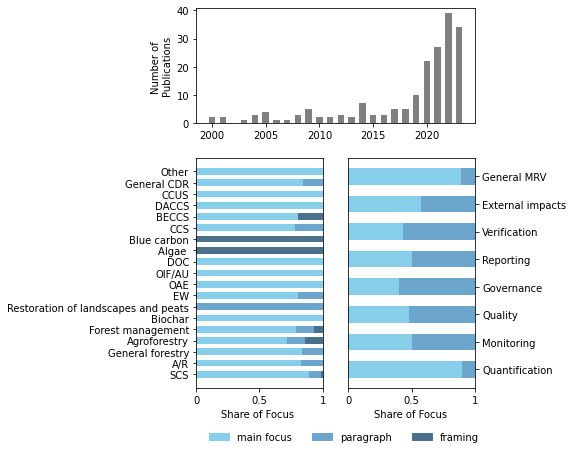

In [104]:
fig = plt.figure(figsize=(5,7))
gs = fig.add_gridspec(2,2,height_ratios=[1,2],width_ratios=[1,1])

##### years
ax1 = fig.add_subplot(gs[0,:])

width=0.6

ax1.bar(paper_per_year["Year"], paper_per_year["size"], width, color="grey")
ax1.set_ylabel('Number of \nPublications')

#### focus  - CDR ######################
focus = [1,2,3]

ax2 = fig.add_subplot(gs[1,0])

prev_values = np.zeros(len(cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==focus[0]]))
for i, f in enumerate(focus):
    #print(topic)
    ax2.barh([i for i in range(len(cdr_method_colors.keys()))], cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==f,"rel"], 
              width, left=prev_values, 
              label=f,
              color=cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==f,"col"])
    prev_values += np.array(cdr_meth_focus.loc[cdr_meth_focus["CDR_focus"]==f,"rel"])
    
ax2.set_xlabel('Share of Focus ')
_=ax2.set_yticks([i for i in range(len(cdr_method_colors.keys()))],[i for i in cdr_method_colors.keys()])

#### focus  - CDR ######################
focus = [1,2,3]

ax3 = fig.add_subplot(gs[1,1])

prev_values = np.zeros(len(cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==focus[0]]))
for i, f in enumerate(focus):
    ax3.barh([i for i in range(len(mrv_topic_colors.keys()))], cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"rel"], 
              width, left=prev_values, 
              label=f,
              color=cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"col"])
    prev_values += np.array(cdr_mrv_focus.loc[cdr_mrv_focus["MRV_focus"]==f,"rel"])
    
ax3.set_xlabel('Share of Focus ')
_ = ax3.set_yticks([i for i in range(len(mrv_topic_colors.keys()))],[i for i in mrv_topic_colors.keys()])
ax3.yaxis.tick_right()
ax3.set_xticks([0,0.5,1],[0,0.5,1])

ax2.set_xticks([0,0.5,1],[0,0.5,1])
ax3.set_xticks([0,0.5,1],[0,0.5,1])

legend = []
legend.append(mpatches.Patch(color=col_focus[1], label="main focus"))
legend.append(mpatches.Patch(color=col_focus[2], label="paragraph"))
legend.append(mpatches.Patch(color=col_focus[3], label="framing"))
leg_res = ax2.legend(handles=legend, bbox_to_anchor=(2.3,-.15), fontsize=10, frameon=False,ncol=3)


fig.savefig('figures/fig1.png', bbox_inches="tight", facecolor='white', edgecolor='none')